In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
sns.set_style('darkgrid')
%matplotlib inline
pd.options.display.max_rows = 10

In [3]:
# load dataset
df= pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe(exclude= ['O']) # Describe all numerical columns

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.describe(include = ['O']) # Describe all categorical columns

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [7]:
# validation framework
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
train_df, test_df = train_test_split(df, train_size=0.75 ,random_state=123)

In [8]:
# preprocessing
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen"]  # don't want to scale tenure
target_column = ["Churn"]
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder)

preprocessing_final = ColumnTransformer([
    ("target_column",FunctionTransformer(lambda x: x == "Yes"),target_column),
    ("passthrough_features","passthrough",passthrough_features),
    ("numeric_features",StandardScaler(), numeric_features),
    ("categorical_features",OneHotEncoder(handle_unknown="ignore", sparse_output=False),categorical_features), # , drop="first"
    ("drop_features","drop",drop_features)
])

preprocessing_final.fit(train_df);

In [9]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
    + preprocessing_final.named_transformers_["categorical_features"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

train_df_surv.head()

,Churn,tenure,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),...,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes
6464,0.0,50.0,1.0,0.185175,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
5707,0.0,2.0,0.0,-0.641538,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3442,0.0,29.0,0.0,1.133562,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3932,1.0,2.0,1.0,0.458524,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
6124,0.0,57.0,0.0,-0.183179,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


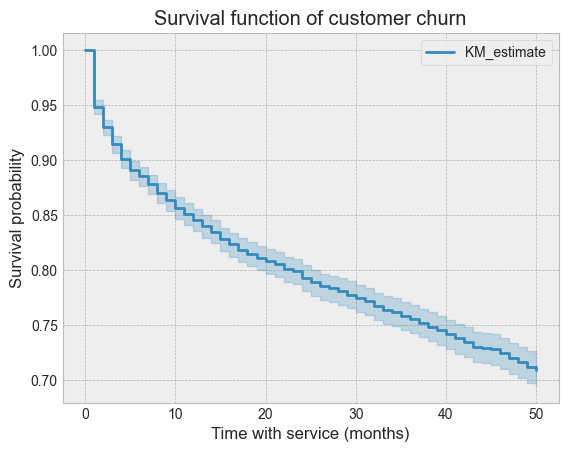

In [10]:
# Kaplan-Meier
import lifelines
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=train_df_surv["tenure"], event_observed=train_df_surv["Churn"], alpha=0.05, timeline=np.linspace(0, 50, 101));

#kmf.survival_function_.plot()
plt.style.use("bmh")
kmf.plot_survival_function()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

In [11]:
# median survival time
kmf.median_survival_time_

from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci


,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,inf,inf


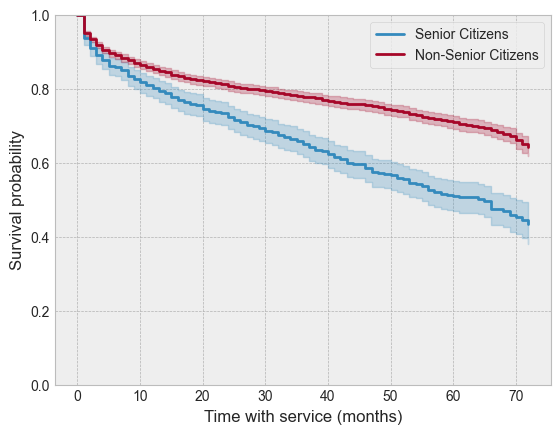

In [12]:
# We can also create the K-M curve for different subgroups:

T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

In [13]:
# And we can test whether the two survival curves are statistically different
from lifelines.statistics import logrank_test

results = logrank_test(T[senior], T[~senior], E[senior], E[~senior], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          85.73 <0.005     65.40

The survival functions is a great way to summarize and visualize the survival dataset, however it is not the only way. If we are curious about the hazard function h(t)
 of a population, we unfortunately cannot transform the Kaplan Meier estimate – statistics doesn’t work quite that well. Fortunately, there is a proper non-parametric estimator of the cumulative hazard function using Nelson-Aalen

# Cox proportional hazards model
* We haven’t been incorporating other features in the model so far.

* The Cox proportional hazards model is a commonly used model that allows us to interpret how features influence a censored tenure/duration.

* You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.

* It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won’t go into this here.

* The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.

In [14]:
#cph = lifelines.CoxPHFitter()
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(train_df_surv, duration_col="tenure", event_col="Churn", formula=None); # formula can be used as in statsmodels
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5282 total observations, 3912 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5282
number of events observed = 1370
   partial log-likelihood = -9988.26
         time fit was run = 2023-05-25 20:33:30 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                       
SeniorCitizen                            -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.10
MonthlyCharges                           -0.00       1.00       0.04            -0.08             0.08                 0.92                 1.08
gender_Female                             0.02       1.02       0.07            -0.11             0.15                 0.89                 1.16
gender_Male                              -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.12
Contract_Month-to-month                   0.81       2.25       0.07             0.68             0.95                 1.97                 2.58
Contract_One year                        -0.35       0.70       0.08            -0.50            -0.20                 0.60                 0.82
Contract_Two year                        -0.78       0.46       0.08            -0.94            -0.62                 0.39                 0.54
PaymentMethod_Bank transfer (automatic)  -0.24       0.78       0.07            -0.38            -0.11                 0.68                 0.90
PaymentMethod_Credit card (automatic)    -0.30       0.74       0.07            -0.44            -0.16                 0.64                 0.85
PaymentMethod_Electronic check            0.28       1.32       0.06             0.16             0.40                 1.17                 1.50
PaymentMethod_Mailed check                0.17       1.19       0.07             0.03             0.31                 1.03                 1.37
DeviceProtection_No                       0.18       1.20       0.07             0.05             0.31                 1.05                 1.37
DeviceProtection_No internet service     -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
DeviceProtection_Yes                     -0.15       0.86       0.07            -0.29            -0.02                 0.75                 0.98
Partner_No                                0.24       1.28       0.07             0.11             0.38                 1.12                 1.46
Partner_Yes                              -0.24       0.78       0.07            -0.38            -0.11                 0.69                 0.89
StreamingTV_No                            0.05       1.05       0.07            -0.08             0.18                 0.92                 1.20
StreamingTV_No internet service          -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
StreamingTV_Yes                          -0.01       0.99       0.07            -0.14             0.13                 0.87                 1.13
InternetService_DSL                      -0.16       0.85       0.07            -0.30            -0.02                 0.74                 0.98
InternetService_Fiber optic               0.19       1.21       0.07             0.05             0.33                 1.05                 1.39
InternetService_No                       -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
OnlineBackup_No                           0.30       1.35       0.07             0.17       

In [25]:
cph_params = pd.DataFrame(cph.params_).sort_values(by = "coef", ascending=False)
#cph.variance_matrix_   # covariance matrix of the coefficients
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
...,...
OnlineBackup_Yes,-0.282600
PaymentMethod_Credit card (automatic),-0.302801
OnlineSecurity_Yes,-0.330346


In [16]:
# you can check the model's assumptions
cph.check_assumptions

<bound method ProportionalHazardMixin.check_assumptions of <lifelines.CoxPHFitter: fitted with 5282 total observations, 3912 right-censored observations>>

<Axes: >

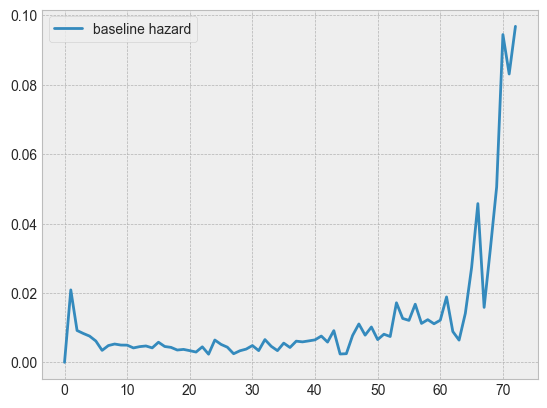

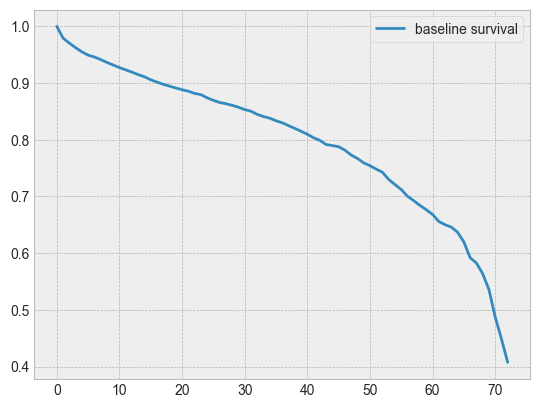

In [17]:
cph.baseline_hazard_.plot() # baseline hazard
cph.baseline_survival_.plot() # baseline survival


In [21]:
# predictions
cph.predict_survival_function(train_df_surv)
cph.predict_median(train_df_surv)
cph.predict_partial_hazard(train_df_surv);

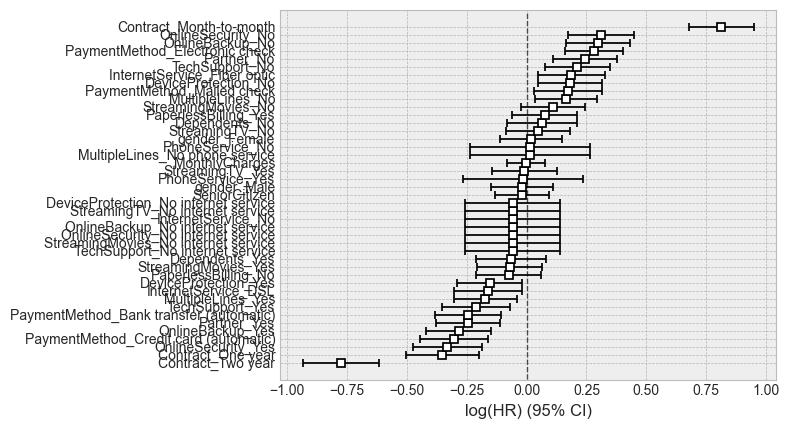

In [23]:
# Plotting the coefficients
cph.plot();

<Axes: >

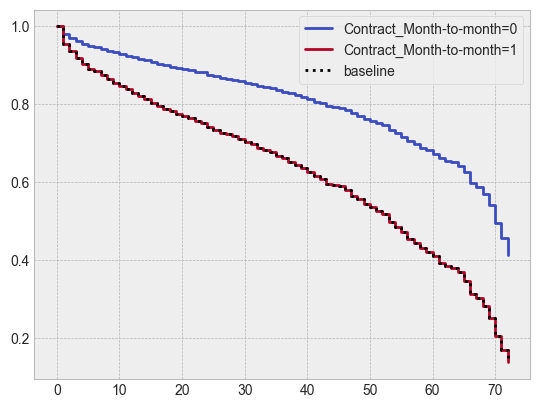

In [30]:
# Plotting the effect of varying a covariate
cph.plot_partial_effects_on_outcome(covariates='Contract_Month-to-month', values=[0, 1], cmap='coolwarm')


# Other approaches / what did we not cover?
There are many other approaches to modelling in survival analysis:

* Time-varying proportional hazards.

* What if some of the features change over time, e.g. plan type, number of lines, etc.

* Approaches based on deep learning, e.g. the pysurvival package.

* Random survival forests.

* And more…